In [1]:
# Load necessary libraries
library(ggplot2)
library(imager)

# Define the path to the 'original' folder
original_dir <- file.path("/kaggle/input/leukemia-images/Original")  # Update this path

# List all class folders inside the 'original' directory
class_folders <- list.dirs(original_dir, recursive = FALSE)

# Initialize a data frame to store image information
df_images <- data.frame()

# Loop through each class folder and extract image info
for (class_folder in class_folders) {
  # List image files in the current class folder
  image_files <- list.files(class_folder, full.names = TRUE, pattern = "\\.(png|jpg|jpeg|tiff|bmp)$")
  
  # Extract class name from the folder name
  class_name <- basename(class_folder)
  
  # Get information for each image and add the class name
  for (image_path in image_files) {
    img <- load.image(image_path)
    width <- dim(img)[1]
    height <- dim(img)[2]
    aspect_ratio <- width / height
    
    # Append to the data frame
    df_images <- rbind(df_images, data.frame(
      file_name = basename(image_path),
      class = class_name,
      width = width,
      height = height,
      aspect_ratio = aspect_ratio,
      stringsAsFactors = FALSE
    ))
  }
}

# Check the structure of the collected data
str(df_images)
head(df_images)

Loading required package: magrittr




Attaching package: ‘imager’




The following object is masked from ‘package:magrittr’:

    add




The following objects are masked from ‘package:stats’:

    convolve, spectrum




The following object is masked from ‘package:graphics’:

    frame




The following object is masked from ‘package:base’:

    save.image




'data.frame':	3256 obs. of  5 variables:
 $ file_name   : chr  "WBC-Benign-001.jpg" "WBC-Benign-002.jpg" "WBC-Benign-003.jpg" "WBC-Benign-004.jpg" ...
 $ class       : chr  "Benign" "Benign" "Benign" "Benign" ...
 $ width       : int  224 224 224 224 224 224 224 224 224 224 ...
 $ height      : int  224 224 224 224 224 224 224 224 224 224 ...
 $ aspect_ratio: num  1 1 1 1 1 1 1 1 1 1 ...


,file_name,class,width,height,aspect_ratio
,<chr>,<chr>,<int>,<int>,<dbl>
1,WBC-Benign-001.jpg,Benign,224,224,1
2,WBC-Benign-002.jpg,Benign,224,224,1
3,WBC-Benign-003.jpg,Benign,224,224,1
4,WBC-Benign-004.jpg,Benign,224,224,1
5,WBC-Benign-005.jpg,Benign,224,224,1
6,WBC-Benign-006.jpg,Benign,224,224,1


In [2]:
# 1. Class Distribution Plot
p <- ggplot(df_images, aes(x = class)) +
  geom_bar(fill = "skyblue") +
  ggtitle("Class Distribution of Images in the Original Folder") +
  xlab("Class") + ylab("Count") +
  theme_minimal()

ggsave("class_distribution.png", plot = p, width = 8, height = 6, dpi = 300)
# Count the number of images in each class
class_counts <- table(df_images$class)

# Print the counts
print(class_counts)



Benign  Early    Pre    Pro 
   504    985    963    804 


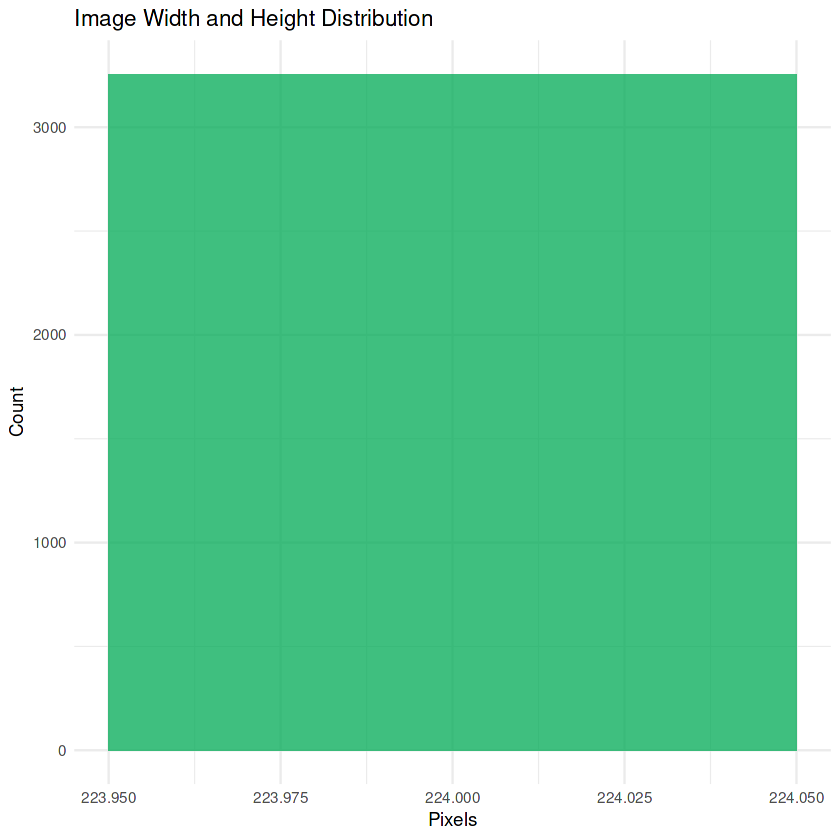

In [3]:
# 2. Image Size Distribution
p <- ggplot(df_images) +
  geom_histogram(aes(x = width), fill = "blue", bins = 20, alpha = 0.5) +
  geom_histogram(aes(x = height), fill = "green", bins = 20, alpha = 0.5) +
  ggtitle("Image Width and Height Distribution") +
  xlab("Pixels") + ylab("Count") +
  theme_minimal()

ggsave("image_size_distribution.png", plot = p, width = 8, height = 6, dpi = 300)
print(p)

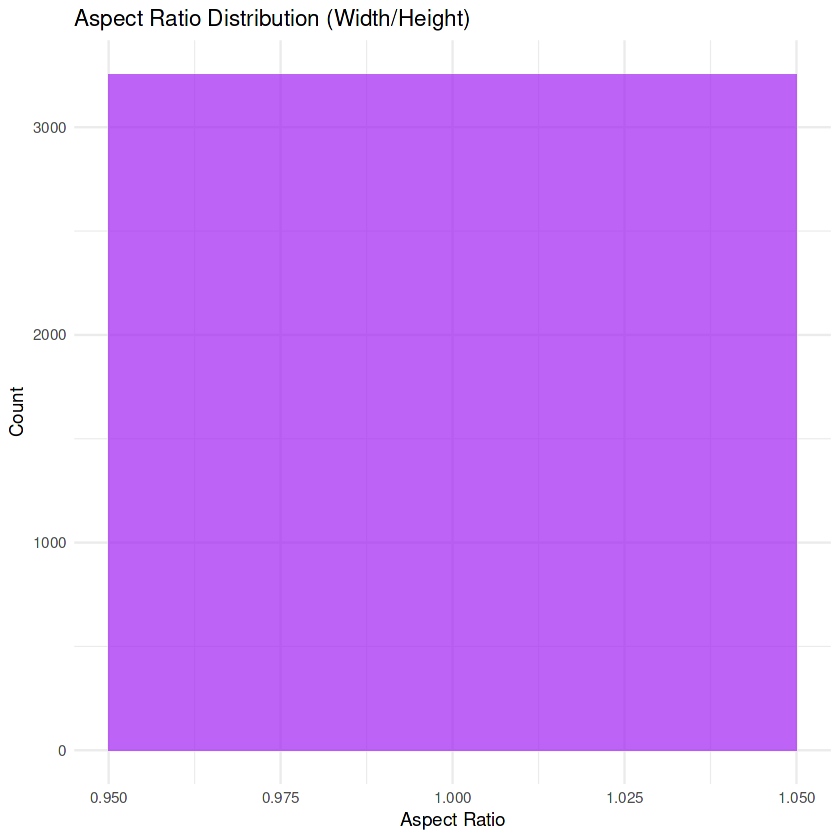

In [4]:
# 3. Aspect Ratio Distribution
p <- ggplot(df_images, aes(x = aspect_ratio)) +
  geom_histogram(fill = "purple", bins = 20, alpha = 0.7) +
  ggtitle("Aspect Ratio Distribution (Width/Height)") +
  xlab("Aspect Ratio") + ylab("Count") +
  theme_minimal()

ggsave("aspect_ratio_distribution.png", plot = p, width = 8, height = 6, dpi = 300)
print(p)


Sample images from class: Benign 



Sample images from class: Early 


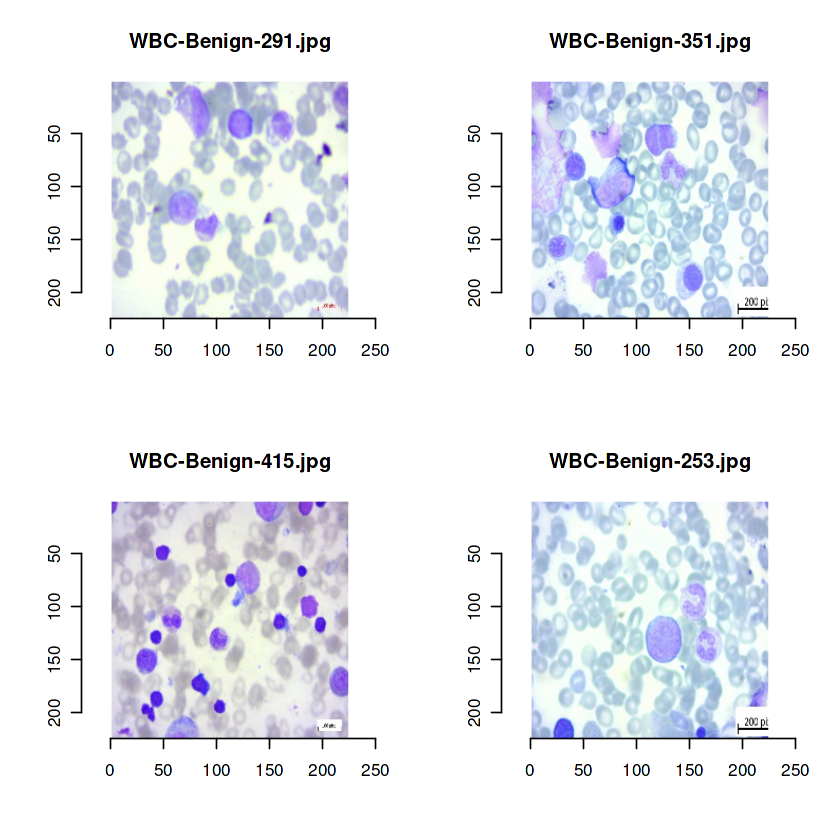


Sample images from class: Pre 


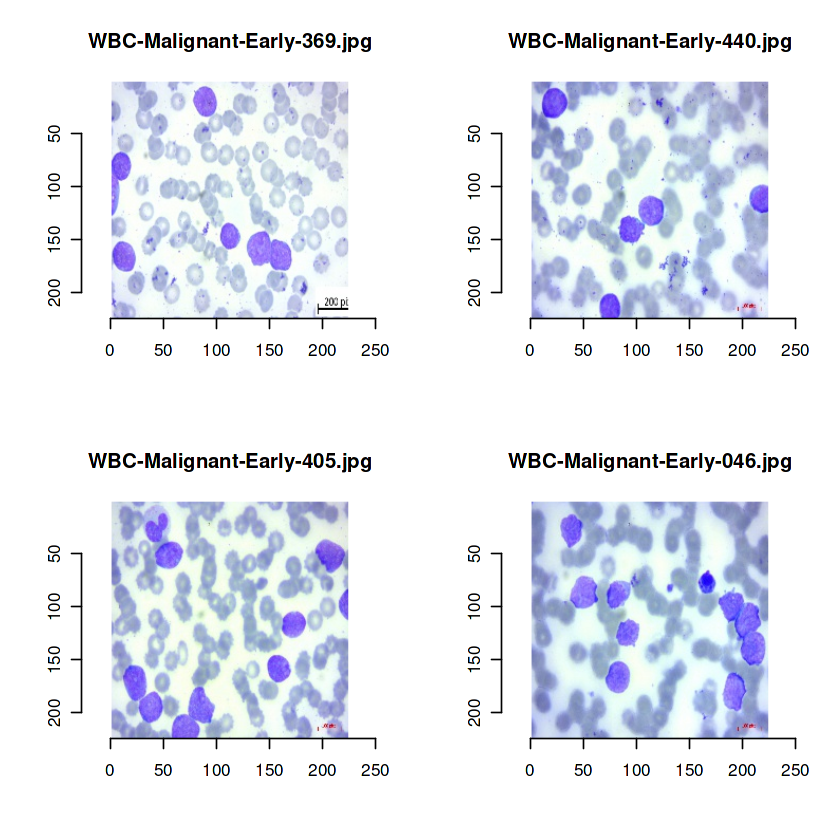


Sample images from class: Pro 


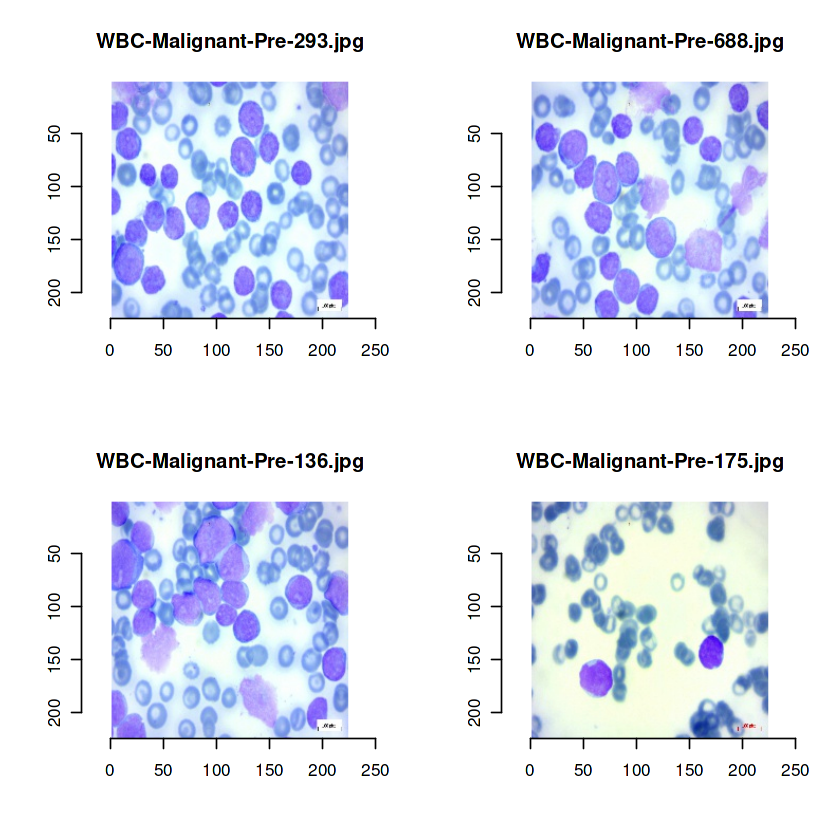

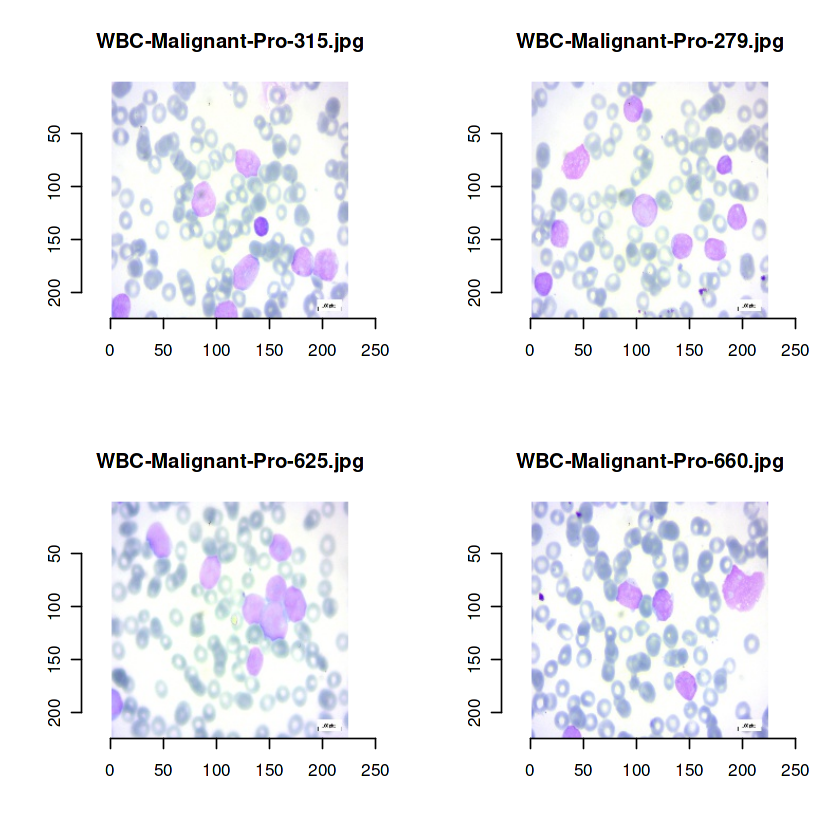

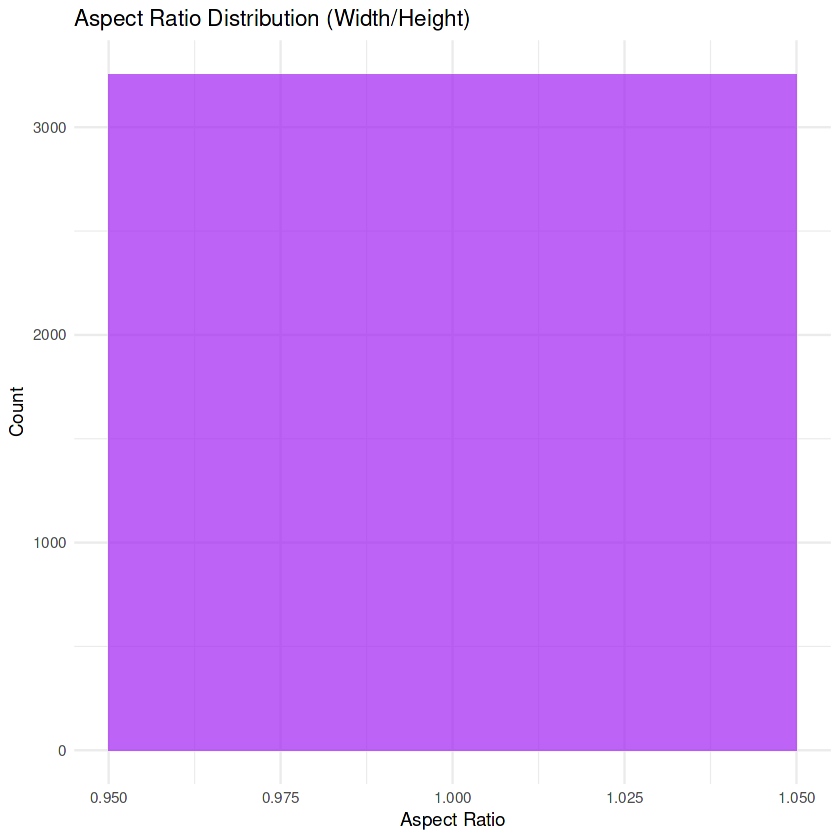

In [5]:
# 4. Visualizing Sample Images from Each Class
plot_sample_images <- function(image_paths, num_images = 4) {
  sample_images <- sample(image_paths, min(num_images, length(image_paths)))
  par(mfrow = c(2, 2))  # Arrange images in a 3x3 grid
  for (image_path in sample_images) {
    img <- load.image(image_path)
    plot(img, main = basename(image_path))
  }
}

# Sample images from each class
for (class_folder in class_folders) {
  class_name <- basename(class_folder)
  class_images <- list.files(class_folder, full.names = TRUE, pattern = "\\.(png|jpg|jpeg|tiff|bmp)$")
  
  cat("\nSample images from class:", class_name, "\n")
  plot_sample_images(class_images)
}
print(p)

In [6]:
# Load necessary libraries
library(keras)
library(tensorflow)
library(dplyr) # For data manipulation

# Set the path to your dataset
data_dir <- "/kaggle/input/leukemia-images/Segmented"

# Define image size and parameters
img_height <- 150
img_width <- 150
batch_size <- 32

# Create a mapping from class names to scores
class_mapping <- c("Benign" = 0, "Early" = 1, "Pre" = 2, "Pro" = 3)

# Create a list to hold all file paths and corresponding labels
file_paths <- c()
class_labels <- c()
scores <- c()

# Loop through each class to gather file paths and scores
for (class in names(class_mapping)) {
  class_path <- file.path(data_dir, class)
  files <- list.files(class_path, full.names = TRUE)
  
  # Ensure files are unique
  unique_files <- unique(files)

  file_paths <- c(file_paths, unique_files)
  class_labels <- c(class_labels, rep(class, length(unique_files)))  # Store the class name
  scores <- c(scores, rep(class_mapping[class], length(unique_files)))  # Store the corresponding score
}

# Create a DataFrame with only the required structure
full_df <- data.frame(
  image_filename = file_paths,
  score = scores,
  class = class_labels,
  stringsAsFactors = FALSE
)

# Shuffle the DataFrame to ensure random sampling
set.seed(123) # For reproducibility
full_df <- full_df[sample(nrow(full_df)), ]

# For displaying filenames without their full paths
display_full_df <- mutate(full_df,image_filename = basename(file_paths))

# Print the full DataFrame
print("Full DataFrame:")
print(head(display_full_df)) # Display the first few rows

# Check the dimensions
print(dim(full_df))  # This should now only have 3 columns


Attaching package: ‘dplyr’




The following object is masked from ‘package:imager’:

    where




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] "Full DataFrame:"


         image_filename score  class
2463 WBC-Benign-001.jpg     3    Pro
2511 WBC-Benign-002.jpg     3    Pro
2227 WBC-Benign-003.jpg     2    Pre
526  WBC-Benign-004.jpg     1  Early
195  WBC-Benign-005.jpg     0 Benign
2986 WBC-Benign-006.jpg     3    Pro


[1] 3256    3
